In [5]:
import os
import glob
import numpy as np
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────
annotation_dir    = "/Volumes/v4/release/annotations/actions/laughing/With_Audio"
participants      = list(range(1, 51))
patterns_to_show  = [(0,0,0),(0,1,0),(0,0,1),(1,0,0),(0,1,1),(1,0,1),(1,1,0),(1,1,1)]
examples_per_pat  = 3

# ─── Helper to read and binarize a CSV ──────────────────────────────────────
def robust_read_and_binarize(path):
    try:
        df = pd.read_csv(path, encoding="latin1", on_bad_lines="skip", dtype=str)
    except:
        with open(path, 'r', encoding='latin1', errors='ignore') as f:
            lines = f.readlines()
        header = lines[0].strip().split(',')
        data   = [l.strip().split(',') for l in lines[1:] if ',' in l]
        df = pd.DataFrame(data, columns=header)
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
    return (df > 0).astype(int)

# ─── Group files by segment ─────────────────────────────────────────────────
seg_groups = {}
for path in glob.glob(os.path.join(annotation_dir, "*.csv")):
    fn = os.path.basename(path).replace('.csv','')
    vid, seg, ann = fn.split('_')
    seg_groups.setdefault((vid, seg), []).append(path)

# ─── Find and print examples for each pattern ───────────────────────────────
for pattern in patterns_to_show:
    print(f"Pattern {pattern}:")
    examples = 0
    for (vid, seg), files in seg_groups.items():
        dfs = [robust_read_and_binarize(fp) for fp in files]
        max_len = max(df.shape[0] for df in dfs)
        for i, df in enumerate(dfs):
            if len(df) < max_len:
                dfs[i] = pd.concat([df, pd.DataFrame(0, index=range(max_len-len(df)), columns=df.columns)], ignore_index=True)
        for pid in participants:
            col = str(pid)
            if col not in dfs[0].columns:
                continue
            stacked = np.vstack([df[col].values for df in dfs]).T
            for frame_idx, triple in enumerate(stacked):
                if tuple(triple) == pattern:
                    t_seconds = frame_idx / 56.0  # adjust fps if needed
                    print(f"  • {vid}_{seg}, participant {pid}, frame {frame_idx} (t={t_seconds:.2f}s)")
                    examples += 1
                    if examples >= examples_per_pat:
                        break
            if examples >= examples_per_pat:
                break
        if examples >= examples_per_pat:
            break
    if examples == 0:
        print("  (no occurrences found)")
    print()


Pattern (0, 0, 0):
  • vid2_seg7, participant 1, frame 0 (t=0.00s)
  • vid2_seg7, participant 1, frame 1 (t=0.02s)
  • vid2_seg7, participant 1, frame 2 (t=0.04s)

Pattern (0, 1, 0):
  • vid2_seg7, participant 1, frame 1418 (t=25.32s)
  • vid2_seg7, participant 1, frame 1419 (t=25.34s)
  • vid2_seg7, participant 1, frame 1420 (t=25.36s)

Pattern (0, 0, 1):
  • vid2_seg7, participant 1, frame 1450 (t=25.89s)
  • vid2_seg7, participant 1, frame 1451 (t=25.91s)
  • vid2_seg7, participant 1, frame 1452 (t=25.93s)

Pattern (1, 0, 0):
  • vid2_seg7, participant 3, frame 639 (t=11.41s)
  • vid2_seg7, participant 3, frame 640 (t=11.43s)
  • vid2_seg7, participant 4, frame 1477 (t=26.38s)

Pattern (0, 1, 1):
  • vid2_seg7, participant 1, frame 1429 (t=25.52s)
  • vid2_seg7, participant 1, frame 1430 (t=25.54s)
  • vid2_seg7, participant 1, frame 1431 (t=25.55s)

Pattern (1, 0, 1):
  • vid2_seg7, participant 4, frame 1471 (t=26.27s)
  • vid2_seg7, participant 4, frame 1472 (t=26.29s)
  • vid2_se

In [6]:
import numpy as np
import pandas as pd

def count_laughs_by_scale(timeline: np.ndarray,
                          fps: int = 56,
                          min_duration_s: float = 0.2):
    """
    Split the timeline iteratively by halves from full length down to minimum,
    and at each scale compute:
      - window_s: window duration in seconds
      - n_windows: total number of windows at this scale
      - n_laughed: windows where any frame==1 (union)
    Returns a DataFrame summarizing counts at each scale.
    """
    min_frames = int(np.ceil(min_duration_s * fps))
    results = []

    # start with full segment
    segments = [(0, len(timeline))]

    while segments:
        # window size in frames for this scale (all segments equal length)
        s0, e0 = segments[0]
        length = e0 - s0
        window_s = length / fps

        # count windows & laughs
        n_windows = len(segments)
        n_laughed = sum(1 for s, e in segments if timeline[s:e].any())

        results.append({
            "window_s": round(window_s,3),
            "n_windows": n_windows,
            "n_laughed": n_laughed
        })

        # prepare next level
        next_segments = []
        for s, e in segments:
            if (e - s) > min_frames:
                mid = s + (e - s) // 2
                next_segments.extend([(s, mid), (mid, e)])
        # stop if no further split possible
        if not next_segments:
            break
        segments = next_segments

    return pd.DataFrame(results)

# Usage Example
df_ann = pd.read_csv("./annotations_csvs/annotations_with_audio.csv")
vid, seg, pid = "vid2", "seg7", 22
sub = (df_ann[(df_ann.video_id==vid) &
              (df_ann.segment   ==seg) &
              (df_ann.participant==pid)]
       .sort_values("frame"))
timeline = sub["label"].values

df_scale = count_laughs_by_scale(timeline, fps=56, min_duration_s=0.2)
print(df_scale)


    window_s  n_windows  n_laughed
0    128.571          1          1
1     64.286          2          2
2     32.143          4          3
3     16.071          8          4
4      8.036         16          5
5      4.018         32          7
6      2.000         64          8
7      1.000        128         10
8      0.500        256         17
9      0.250        512         26
10     0.125       1024         43


In [11]:
import numpy as np
import pandas as pd

def minimal_laugh_leaves_in_window(timeline: np.ndarray,
                                   start: int,
                                   end: int,
                                   fps: int,
                                   min_duration_s: float):
    """
    Count how many minimal (<min_duration_s) laugh segments occur within [start:end).
    """
    min_frames = int(np.ceil(min_duration_s * fps))
    count = 0

    def recurse(s, e):
        nonlocal count
        length = e - s
        if length > min_frames:
            mid = s + length // 2
            recurse(s, mid)
            recurse(mid, e)
        else:
            # this is a minimal leaf
            if timeline[s:e].any():
                count += 1

    recurse(start, end)
    return count

def laugh_counts_by_window_scale(timeline: np.ndarray,
                                 fps: int = 56,
                                 min_duration_s: float = 0.2):
    """
    Iteratively split the full timeline in halves until <=min_duration_s,
    and at each scale print:
      Window {window_s}s: total windows={n}, laugh counts per window={counts}
    where counts[i] = number of minimal laugh leaves inside window i.
    """
    min_frames = int(np.ceil(min_duration_s * fps))
    segments = [(0, len(timeline))]

    while segments:
        # compute window size in seconds
        s0, e0 = segments[0]
        window_s = round((e0 - s0) / fps, 3)

        # for each segment, count minimal laugh leaves inside it
        counts = []
        for s, e in segments:
            c = minimal_laugh_leaves_in_window(timeline, s, e, fps, min_duration_s)
            counts.append(c)

        print(f"Window {window_s}s: total windows={len(segments)}, laugh counts per window={counts}")

        # prepare next scale by halving
        next_segs = []
        for s, e in segments:
            if (e - s) > min_frames:
                mid = s + (e - s) // 2
                next_segs += [(s, mid), (mid, e)]
        segments = next_segs


In [49]:
import pandas as pd

df_ann = pd.read_csv("./annotations_csvs/annotations_with_audio.csv")
vid, seg, pid = "vid2", "seg7", 16
sub = df_ann[
    (df_ann.video_id==vid)&
    (df_ann.segment  ==seg)&
    (df_ann.participant==pid)
].sort_values("frame")
timeline = sub["label"].values  # array de 0/1

laugh_counts_by_window_scale(timeline, fps=56, min_duration_s=1)


Window 128.571s: total windows=1, laugh counts per window=[41]
Window 64.286s: total windows=2, laugh counts per window=[19, 22]
Window 32.143s: total windows=4, laugh counts per window=[10, 9, 4, 18]
Window 16.071s: total windows=8, laugh counts per window=[7, 3, 8, 1, 4, 0, 14, 4]
Window 8.036s: total windows=16, laugh counts per window=[3, 4, 0, 3, 2, 6, 1, 0, 1, 3, 0, 0, 10, 4, 0, 4]
Window 4.018s: total windows=32, laugh counts per window=[0, 3, 3, 1, 0, 0, 0, 3, 2, 0, 3, 3, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 5, 5, 4, 0, 0, 0, 1, 3]
Window 2.0s: total windows=64, laugh counts per window=[0, 0, 0, 3, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 3, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1]
Window 1.0s: total windows=128, laugh counts per window=[0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 

In [35]:
import numpy as np
import pandas as pd

def count_runs(t: np.ndarray) -> int:
    """Count contiguous runs of 1 in a 1D binary array."""
    # a run starts whenever a 0→1 transition occurs
    # plus if the very first element is 1
    return int(((t[:-1] == 0) & (t[1:] == 1)).sum() + (1 if t[0]==1 else 0))

def total_runs_for_window(timeline: np.ndarray,
                          fps: int,
                          window_s: float) -> int:
    """
    Split timeline into NON‐OVERLAPPING windows of length window_s (sec),
    count runs in each, and return the sum.
    """
    w = int(window_s * fps)
    n = len(timeline) // w
    runs = 0
    for i in range(n):
        slice_ = timeline[i*w:(i+1)*w]
        runs += count_runs(slice_)
    # optionally handle a trailing partial window:
    tail = timeline[n*w:]
    if len(tail)>0:
        runs += count_runs(tail)
    return runs

# ── Load your single timeline ───────────────────────────────────────────────
df_ann = pd.read_csv("./annotations_csvs/annotations_with_audio.csv")
sub = df_ann[
    (df_ann.video_id=="vid2") &
    (df_ann.segment =="seg7") &
    (df_ann.participant==22)
].sort_values("frame")
timeline = sub["label"].values
fps = 25

# ── Sweep possible window sizes to find total_runs == 8 ────────────────────
results = []
for window_s in np.linspace(0.5, 5.0, 46):   # from 0.5s to 5.0s in 0.1s steps
    runs = total_runs_for_window(timeline, fps, window_s)
    results.append((round(window_s,2), runs))

df = pd.DataFrame(results, columns=["window_s","run_count"])
print(df)

print("\nWindow sizes yielding exactly 8 runs:")
print(df[df.run_count==8])


    window_s  run_count
0        0.5         30
1        0.6         26
2        0.7         21
3        0.8         20
4        0.9         16
5        1.0         20
6        1.1         17
7        1.2         17
8        1.3         17
9        1.4         14
10       1.5         14
11       1.6         12
12       1.7         12
13       1.8         15
14       1.9         13
15       2.0         13
16       2.1         11
17       2.2         10
18       2.3         11
19       2.4         13
20       2.5         10
21       2.6         11
22       2.7         11
23       2.8          9
24       2.9         10
25       3.0         12
26       3.1         11
27       3.2         11
28       3.3         10
29       3.4         11
30       3.5         10
31       3.6         12
32       3.7          8
33       3.8         10
34       3.9          9
35       4.0          8
36       4.1          7
37       4.2          7
38       4.3          7
39       4.4          8
40       4.5    

In [10]:
import os
import glob
import pickle
import numpy as np
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────
annotation_dir = "./annotations_csvs"      # contains annotations_{modality}.csv
pkls_dir       = "./pkls"                  # participant .pkl files
output_dir     = "./pipeline_outputs"
os.makedirs(output_dir, exist_ok=True)

fps = 25                                    # frames per second
min_duration_s = 1                       # your chosen minimal window

# ─── HELPERS ───────────────────────────────────────────────────────────────

def count_runs(arr: np.ndarray) -> int:
    """Count contiguous 1‐runs in a 0/1 array."""
    return int(((arr[:-1]==0)&(arr[1:]==1)).sum() + (1 if arr[0]==1 else 0))

def recurse_windows(arr: np.ndarray, start: int, end: int, rec_level: int):
    """
    Recursively split [start:end) until <= min_frames.
    Return list of dicts for every node in the tree.
    """
    min_frames = int(np.ceil(min_duration_s * fps))
    length = end - start
    record = {
        'start_frame': start,
        'end_frame':   end,
        'duration_s':  length / fps,
        'run_count':   count_runs(arr[start:end]),
        'level':       rec_level
    }
    nodes = [record]
    if length > min_frames:
        mid = start + length//2
        nodes += recurse_windows(arr, start, mid, rec_level+1)
        nodes += recurse_windows(arr, mid, end, rec_level+1)
    return nodes

# ─── 1. LOAD & GROUP ANNOTATIONS ────────────────────────────────────────────
all_windows = []
for modality in ["No_Audio","Only_Audio","With_Audio"]:
    path = os.path.join(annotation_dir, f"annotations_{modality.lower()}.csv")
    df = pd.read_csv(path)
    for (vid, seg, pid), sub in df.groupby(['video_id','segment','participant']):
        arr = sub.sort_values('frame')['label'].values.astype(int)
        # ─── 2. RECURSIVE SPLIT & COUNT ───────────────────────────────────
        nodes = recurse_windows(arr, 0, len(arr), rec_level=0)
        for n in nodes:
            n.update({'modality': modality,
                      'video_id': vid,
                      'segment': seg,
                      'participant': pid})
        all_windows.extend(nodes)

df_windows = pd.DataFrame(all_windows)

# ─── 3. SAVE FULL TREE ─────────────────────────────────────────────────────
full_csv = os.path.join(output_dir, "windows_full_tree.csv")
df_windows.to_csv(full_csv, index=False)
print("✅ Full tree saved to", full_csv)

# ─── 4. FILTER MINIMAL LEAVES ───────────────────────────────────────────────
df_leaves = df_windows[df_windows['duration_s'] <= min_duration_s + 1e-6].copy()

# Aseguramos que run_count sea 0 o 1 (el resto vendría de errores de segmentación)
df_leaves["run_count"] = df_leaves["run_count"].clip(upper=1)
df_leaves["label"] = df_leaves["run_count"]  # Definimos label directamente

# Guardamos solo las hojas mínimas con label limpio
leaf_csv = os.path.join(output_dir, f"windows_min_{min_duration_s}s.csv")
df_leaves.to_csv(leaf_csv, index=False)
print("✅ Minimal windows saved to", leaf_csv)

# Extra: verificación rápida de distribución de etiquetas
print("ℹ️ Label distribution in leaves:")
print(df_leaves["label"].value_counts())



✅ Full tree saved to ./pipeline_outputs/windows_full_tree.csv
✅ Minimal windows saved to ./pipeline_outputs/windows_min_1s.csv
ℹ️ Label distribution in leaves:
label
0    1562446
1      88754
Name: count, dtype: int64


In [11]:
import os
import pickle
import numpy as np
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────
pipeline_dir = "./pipeline_outputs"
features_dir = "./features_csvs"
pkls_dir      = "./pkls"
os.makedirs(features_dir, exist_ok=True)

win_size = 1

# These match the names actually in your PKL DataFrames:
filtered_cols = ["accelX_filtered", "accelY_filtered", "accelZ_filtered"]

# ─── 1. LOAD THE MINIMAL-WINDOW CSV ────────────────────────────────────────
min_csv = os.path.join(pipeline_dir, f"windows_min_{win_size}s.csv")
df_segs = pd.read_csv(min_csv)

# Check what columns you have:
print("SEGMENT CSV COLUMNS:", df_segs.columns.tolist())

# We expect columns: ['video_id','segment','participant',
#   'start_frame','end_frame','start_s','end_s','run_count','label']

# ─── 2. PRELOAD SIGNALS ────────────────────────────────────────────────────
signals = {}
for pid in df_segs["participant"].unique():
    pkl_path = os.path.join(pkls_dir, f"{pid}.pkl")
    if not os.path.exists(pkl_path):
        print(f"⚠️ Skipping p{pid}: no PKL found")
        continue
    with open(pkl_path, "rb") as f:
        df_sig = pickle.load(f)
    # Debug: list your df_sig cols once
    if pid == df_segs["participant"].unique()[0]:
        print("SAMPLE PKL COLUMNS:", df_sig.columns.tolist())
    # Ensure 'time' and the filtered_cols exist
    if "time" in df_sig.columns and all(c in df_sig.columns for c in filtered_cols):
        signals[pid] = df_sig
    else:
        print(f"⚠️ Skipping p{pid}: missing required columns")

# ─── 3. FEATURE EXTRACTION FUNCTION ────────────────────────────────────────
def extract_features_segment(df_sig, start_t, end_t):
    seg = df_sig[(df_sig["time"] >= start_t) & (df_sig["time"] < end_t)]
    X = seg[filtered_cols].values
    feats = {}
    # time-domain stats
    for col in filtered_cols:
        arr = seg[col].values
        feats[f"{col}_mean"]   = arr.mean()    if len(arr)>0 else 0
        feats[f"{col}_var"]    = arr.var()     if len(arr)>0 else 0
        feats[f"{col}_energy"] = (arr**2).sum() if len(arr)>0 else 0
    # derivatives
    if X.shape[0] > 1:
        d = np.diff(X, axis=0)
        for i, col in enumerate(filtered_cols):
            darr = d[:, i]
            feats[f"{col}_deriv_mean"] = darr.mean()
            feats[f"{col}_deriv_std"]  = darr.std()
    else:
        for col in filtered_cols:
            feats[f"{col}_deriv_mean"] = 0
            feats[f"{col}_deriv_std"]  = 0
    # SMA
    feats["SMA"] = np.abs(X).sum()
    # correlations
    if X.shape[0] > 1:
        feats["corr_xy"] = np.corrcoef(X[:,0], X[:,1])[0,1]
        feats["corr_xz"] = np.corrcoef(X[:,0], X[:,2])[0,1]
        feats["corr_yz"] = np.corrcoef(X[:,1], X[:,2])[0,1]
    else:
        feats.update({"corr_xy":0, "corr_xz":0, "corr_yz":0})
    return feats

# ─── 4. EXTRACT FEATURES FOR EACH WINDOW ───────────────────────────────────
records = []
fps = 25.0

for _, row in df_segs.iterrows():
    pid = int(row["participant"])
    if pid not in signals:
        continue
    df_sig = signals[pid]

    # Use the start_s / end_s columns if available:
    if "start_s" in row and "end_s" in row:
        start_t = row["start_s"]
        end_t   = row["end_s"]
    else:
        # fallback to frames
        start_t = row["start_frame"] / fps
        end_t   = row["end_frame"]   / fps

    feats = extract_features_segment(df_sig, start_t, end_t)
    # add context
    feats.update({
        "modality":    row["modality"],
        "video_id":    row["video_id"],
        "segment":     row["segment"],
        "participant": pid,
        "start_s":     start_t,
        "end_s":       end_t,
        "run_count":   int(row["run_count"]),
        "label":       int(row["label"])
    })
    records.append(feats)

df_features = pd.DataFrame(records)

# ─── 5. SAVE THE FEATURE DATASET ───────────────────────────────────────────
out_csv = os.path.join(features_dir, f"features_fixed_{win_size}s.csv")
df_features.to_csv(out_csv, index=False)
print(f"✅ Extracted {len(df_features)} windows → {out_csv}")


SEGMENT CSV COLUMNS: ['start_frame', 'end_frame', 'duration_s', 'run_count', 'level', 'modality', 'video_id', 'segment', 'participant', 'label']
SAMPLE PKL COLUMNS: ['time', 'accelX', 'accelY', 'accelZ', 'gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ', 'rotA', 'rotB', 'rotC', 'rotD', 'rssi', 'accelX_filtered', 'accelY_filtered', 'accelZ_filtered']
⚠️ Skipping p38: no PKL found
⚠️ Skipping p39: no PKL found
✅ Extracted 1585152 windows → ./features_csvs/features_fixed_1s.csv


In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────
annotation_dir = "./annotations_csvs"      # contains annotations_{modality}.csv
pkls_dir       = "./pkls"                  # participant .pkl files
output_dir     = "./pipeline_outputs"
os.makedirs(output_dir, exist_ok=True)

fps = 25                                    # frames per second
min_duration_s = 10                       # your chosen minimal window

# ─── HELPERS ───────────────────────────────────────────────────────────────

def count_runs(arr: np.ndarray) -> int:
    """Count contiguous 1‐runs in a 0/1 array."""
    return int(((arr[:-1]==0)&(arr[1:]==1)).sum() + (1 if arr[0]==1 else 0))

def recurse_windows(arr: np.ndarray, start: int, end: int, rec_level: int):
    """
    Recursively split [start:end) until <= min_frames.
    Return list of dicts for every node in the tree.
    """
    min_frames = int(np.ceil(min_duration_s * fps))
    length = end - start
    record = {
        'start_frame': start,
        'end_frame':   end,
        'duration_s':  length / fps,
        'run_count':   count_runs(arr[start:end]),
        'level':       rec_level
    }
    nodes = [record]
    if length > min_frames:
        mid = start + length//2
        nodes += recurse_windows(arr, start, mid, rec_level+1)
        nodes += recurse_windows(arr, mid, end, rec_level+1)
    return nodes

# ─── 1. LOAD & GROUP ANNOTATIONS ────────────────────────────────────────────
all_windows = []
for modality in ["No_Audio","Only_Audio","With_Audio"]:
    path = os.path.join(annotation_dir, f"annotations_{modality.lower()}.csv")
    df = pd.read_csv(path)
    for (vid, seg, pid), sub in df.groupby(['video_id','segment','participant']):
        arr = sub.sort_values('frame')['label'].values.astype(int)
        # ─── 2. RECURSIVE SPLIT & COUNT ───────────────────────────────────
        nodes = recurse_windows(arr, 0, len(arr), rec_level=0)
        for n in nodes:
            n.update({'modality': modality,
                      'video_id': vid,
                      'segment': seg,
                      'participant': pid})
        all_windows.extend(nodes)

df_windows = pd.DataFrame(all_windows)

# ─── 3. SAVE FULL TREE ─────────────────────────────────────────────────────
full_csv = os.path.join(output_dir, "windows_full_tree.csv")
df_windows.to_csv(full_csv, index=False)
print("✅ Full tree saved to", full_csv)

# ─── 4. FILTER MINIMAL LEAVES ───────────────────────────────────────────────
df_leaves = df_windows[df_windows['duration_s'] <= min_duration_s + 1e-6].copy()

# Aseguramos que run_count sea 0 o 1 (el resto vendría de errores de segmentación)
df_leaves["run_count"] = df_leaves["run_count"].clip(upper=1)
df_leaves["label"] = df_leaves["run_count"]  # Definimos label directamente

# Guardamos solo las hojas mínimas con label limpio
leaf_csv = os.path.join(output_dir, f"windows_min_{min_duration_s}s.csv")
df_leaves.to_csv(leaf_csv, index=False)
print("✅ Minimal windows saved to", leaf_csv)

# Extra: verificación rápida de distribución de etiquetas
print("ℹ️ Label distribution in leaves:")
print(df_leaves["label"].value_counts())



✅ Full tree saved to ./pipeline_outputs/windows_full_tree.csv
✅ Minimal windows saved to ./pipeline_outputs/windows_min_10s.csv
ℹ️ Label distribution in leaves:
label
0    93388
1    17012
Name: count, dtype: int64


In [2]:
import os
import pickle
import numpy as np
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────
pipeline_dir = "./pipeline_outputs"
features_dir = "./features_csvs"
pkls_dir     = "./pkls"
os.makedirs(features_dir, exist_ok=True)

tree_csv = os.path.join(pipeline_dir, "windows_full_tree.csv")
df_tree = pd.read_csv(tree_csv)

# Optional: filter by a minimum duration if needed
# df_tree = df_tree[df_tree["duration_s"] >= 1.0]  # e.g., keep segments ≥ 1s

# ─── PARAMETERS ────────────────────────────────────────────────────────────
filtered_cols = ["accelX_filtered", "accelY_filtered", "accelZ_filtered"]
fps = 25.0

# ─── 1. PRELOAD SIGNALS ────────────────────────────────────────────────────
signals = {}
for pid in df_tree["participant"].unique():
    pkl_path = os.path.join(pkls_dir, f"{pid}.pkl")
    if not os.path.exists(pkl_path):
        print(f"⚠️ Skipping p{pid}: no PKL found")
        continue
    with open(pkl_path, "rb") as f:
        df_sig = pickle.load(f)
    if "time" in df_sig.columns and all(c in df_sig.columns for c in filtered_cols):
        signals[pid] = df_sig
    else:
        print(f"⚠️ Skipping p{pid}: missing required columns")

# ─── 2. FEATURE EXTRACTION ─────────────────────────────────────────────────
def extract_features_segment(df_sig, start_t, end_t):
    seg = df_sig[(df_sig["time"] >= start_t) & (df_sig["time"] < end_t)]
    X = seg[filtered_cols].values
    feats = {}
    for col in filtered_cols:
        arr = seg[col].values
        feats[f"{col}_mean"]   = arr.mean()    if len(arr)>0 else 0
        feats[f"{col}_var"]    = arr.var()     if len(arr)>0 else 0
        feats[f"{col}_energy"] = (arr**2).sum() if len(arr)>0 else 0
    if X.shape[0] > 1:
        d = np.diff(X, axis=0)
        for i, col in enumerate(filtered_cols):
            darr = d[:, i]
            feats[f"{col}_deriv_mean"] = darr.mean()
            feats[f"{col}_deriv_std"]  = darr.std()
    else:
        for col in filtered_cols:
            feats[f"{col}_deriv_mean"] = 0
            feats[f"{col}_deriv_std"]  = 0
    feats["SMA"] = np.abs(X).sum()
    if X.shape[0] > 1:
        feats["corr_xy"] = np.corrcoef(X[:,0], X[:,1])[0,1]
        feats["corr_xz"] = np.corrcoef(X[:,0], X[:,2])[0,1]
        feats["corr_yz"] = np.corrcoef(X[:,1], X[:,2])[0,1]
    else:
        feats.update({"corr_xy":0, "corr_xz":0, "corr_yz":0})
    return feats

# ─── 3. LOOP OVER ALL SEGMENTS IN TREE ─────────────────────────────────────
records = []
for _, row in df_tree.iterrows():
    pid = int(row["participant"])
    if pid not in signals:
        continue
    df_sig = signals[pid]
    start_t = row["start_frame"] / fps
    end_t   = row["end_frame"]   / fps
    feats = extract_features_segment(df_sig, start_t, end_t)
    feats.update({
        "modality":    row["modality"],
        "video_id":    row["video_id"],
        "segment":     row["segment"],
        "participant": pid,
        "start_s":     start_t,
        "end_s":       end_t,
        "duration_s":  row["duration_s"],
        "run_count":   int(row["run_count"]),
        "level":       int(row["level"]),
        "label":       int(row["run_count"] > 0)  # or use another label strategy
    })
    records.append(feats)

df_features = pd.DataFrame(records)

# ─── 4. SAVE THE OUTPUT ────────────────────────────────────────────────────
out_path = os.path.join(features_dir, "features_full_tree.csv")
df_features.to_csv(out_path, index=False)
print(f"✅ Extracted {len(df_features)} segments → {out_path}")


⚠️ Skipping p38: no PKL found
⚠️ Skipping p39: no PKL found
✅ Extracted 208656 segments → ./features_csvs/features_full_tree.csv


['accelX_filtered_mean', 'accelX_filtered_var', 'accelX_filtered_energy', 'accelY_filtered_mean', 'accelY_filtered_var', 'accelY_filtered_energy', 'accelZ_filtered_mean', 'accelZ_filtered_var', 'accelZ_filtered_energy', 'accelX_filtered_deriv_mean', 'accelX_filtered_deriv_std', 'accelY_filtered_deriv_mean', 'accelY_filtered_deriv_std', 'accelZ_filtered_deriv_mean', 'accelZ_filtered_deriv_std', 'SMA', 'corr_xy', 'corr_xz', 'corr_yz', 'modality', 'video_id', 'segment', 'participant', 'start_s', 'end_s', 'duration_s', 'run_count', 'level', 'label']


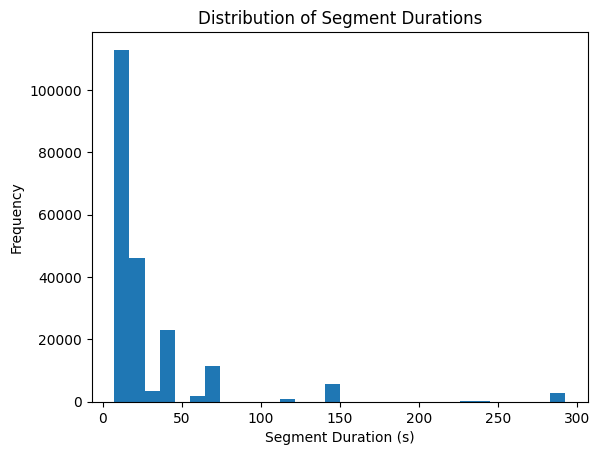

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./features_csvs/features_full_tree.csv")

# Basic stats
#print(df["duration_s"].describe())
#print(df["label"].value_counts())
print(df.columns.tolist())


# Histogram
plt.hist(df["duration_s"], bins=30)
plt.xlabel("Segment Duration (s)")
plt.ylabel("Frequency")
plt.title("Distribution of Segment Durations")
plt.show()


In [3]:
import pandas as pd
df = pd.read_csv("./features_csvs/features_full_tree.csv")
print(df[df["participant"] == 22]["run_count"].sort_values(ascending=False))


79947     23
22491     22
73899     20
125307    20
1323      18
          ..
110244     0
110245     0
110246     0
110247     0
34621      0
Name: run_count, Length: 4347, dtype: int64


In [4]:
df_22 = df[df["participant"] == 22].sort_values(by=["start_s", "run_count"], ascending=[True, False])
print(df_22[["start_s", "duration_s", "run_count"]])


        start_s  duration_s  run_count
79947      0.00      288.28         23
22491      0.00      288.04         22
73899      0.00      292.60         20
125307     0.00      288.24         20
1323       0.00      288.00         18
...         ...         ...        ...
128393   283.08        9.16          0
86057    283.12        9.16          0
89081    283.12        9.16          0
95129    283.12        9.16          0
73961    283.44        9.16          0

[4347 rows x 3 columns]
